# Goodness of Fit

The recommended bibliography to study this kind of problems is [Probability and Statistics in Particle Physics](https://user.pa.msu.edu/linnemann/public/milagro/froedeson.pdf "Froedeson"). In particular, chapter 10.4.4 is titled goodness of fit and has a few paragraphs on describing this problem. Unfortunately, the preceding sections of the chapter are probably necessary for understanding.

## Importing

Let's begin by importing some esential packages.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.stats as st

from ipywidgets import interact

# Experimental Setup

To begin with, we need to suppose we are performing an experiment from which we are going to acquire data points that we wish to compare with a model we have. This could be a constant value we wish to measure, a time series of a damped oscillator or any experiment. In this case, we will consider a RC circuit and we will be measuring its transient response. To begin with, we will state the different constants of our setup.

<img src="https://i.stack.imgur.com/3Igzf.png" alt="Drawing" style="width: 300px;"/>

In [4]:
V_in = 10  # Volts
R = 5000  # Ohms
C = 0.1 * 10 ** (-6)  # Faraday

After performing some calculations on our model of the circuit, we know the current is going to behave following the equation

$$i(t) = \frac{V_{in} - V_C(0)}{R}  e^\frac{-t}{\tau},$$

where $V_C (0)$ is the initial voltage of the capacitance and $\tau = 1 / RC$.

In [5]:
def current(t, Amp, tau):
    return Amp * np.exp(-t / tau)

The estimated parameters according to the values we set up at the beginning are:

In [6]:
estimated_amp = V_in / R
estimated_tau = R * C

print(f'Estimated Paramters are:\nAmplitude: {estimated_amp:.2e}\ntau: {estimated_tau:.2e}')

Estimated Paramters are:
Amplitude: 2.00e-03
tau: 5.00e-04


## Measurment and Experiment

Now we will imagine that we take some measurements from our imagined experiment.

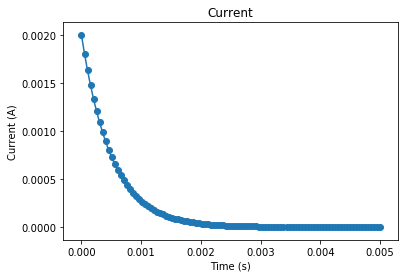

In [7]:
ts_for_plot = np.linspace(0, 0.005, 10000)
ts = np.linspace(0, 0.005, 100)

i_for_plot = current(ts_for_plot, estimated_amp, estimated_tau)
i = current(ts, estimated_amp, estimated_tau)

plt.plot(ts_for_plot, i_for_plot)
plt.scatter(ts, i)

plt.title('Current')
plt.ylabel('Current (A)')
plt.xlabel('Time (s)')
plt.show()

This does not look like a real experiment because there is no noise in the measurements. As each measure is a combination from several factors, let's assume there is gaussian noise in the measurements with a standard deviation of $\sigma$.

In [8]:
sigma_exp = 0.0001
i_exp = i + np.random.normal(0, sigma_exp, len(i))

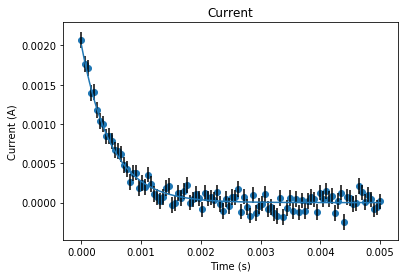

In [9]:
plt.plot(ts_for_plot, i_for_plot)
plt.errorbar(ts, i_exp, sigma_exp, fmt='none', color='k')
plt.scatter(ts, i_exp)

plt.title('Current')
plt.ylabel('Current (A)')
plt.xlabel('Time (s)')

plt.show()

The next step would be to fit the data with our model and try to recover the same parameters.

In [10]:
popt, pcov = curve_fit(current, ts, i_exp, sigma=[sigma_exp] * len(i_exp), p0=[estimated_amp, estimated_tau])

In [11]:
print('Fit Parameters')
print('--------------')
print(f'Amplitude: %.2e +/- %.1e' % (popt[0], np.sqrt(pcov[0, 0])))
print(f'Tau: %.2e +/- %.1e' % (popt[1], np.sqrt(pcov[1, 1])))

Fit Parameters
--------------
Amplitude: 2.02e-03 +/- 5.2e-05
Tau: 4.93e-04 +/- 1.9e-05


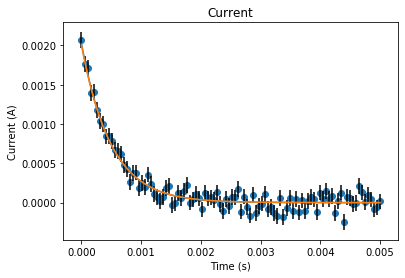

In [12]:
i_fit_for_plot = current(ts_for_plot, *popt)

plt.plot(ts_for_plot, i_fit_for_plot)

plt.plot(ts_for_plot, i_for_plot)
plt.errorbar(ts, i_exp, sigma_exp, fmt='none', color='k')
plt.scatter(ts, i_exp)

plt.title('Current')
plt.ylabel('Current (A)')
plt.xlabel('Time (s)')
plt.show()

## Calculating goodness-of-fit

### Reduced &Chi;^2 and p-value

We will estimate the &Chi;^2 using the formula

$$\chi^2 = \sum \left( \frac{y_{observed} - y_{model}}{\sigma} \right)^2.$$

And after calculating this we will need to estimate the reduced chi or the p-value. For both of them it is necessary to adequately calculate the degrees of freedom following the formula

$$\nu = n - 1 - dof,$$

being n the amount of data points and dof the free parameters fitted.

For estimation of reduced &Chi;^2 we will use

$$red_chi = \chi^2/\nu,$$

but for the estimation of the p-value, we need to perform the integration stated in the proposed bibliography,

$$p = \int_{\chi^2}^{\inf} f(u;\nu) du,$$

being f the $\chi^2$ probability distribution function with $\nu$ degrees of freedom.

### r-squared

If we were to estimate the r-squared we would need to estimate the mean of the measured points, the total sum of squares, and the residual sum of squares

$$\overline{y} = \frac{1}{N} \sum_1^N y_i$$

$$SS_{Tot} = \sum_i (y_i - \overline{y})^2$$

$$SS_Res = \sum_i (y_i - f(x_i))^2$$

$$R^2 = 1 - \frac{SS_{Tot}}{SS_{Res}}$$

Based on a [stackoverflow answer](https://stackoverflow.com/questions/19189362/getting-the-r-squared-value-using-curve-fit). And we can go to [wikipedia](https://en.wikipedia.org/wiki/Coefficient_of_determination) to look for interpretations.

In [13]:
def chi_square(y_data, y_model, sigma):
    return np.sum((y_data/sigma - y_model/sigma)**2)

def r_chi_square(chi, y_data, dof):
    nu = len(y_data) - 1 - dof
    if nu < 1:
        raise ValueError('length of y_data - 1 - dof should be greater than 1')
    return chi / nu

def p_value(chi, y_data, dof):
    nu = len(y_data) - 1 - dof
    if nu < 1:
        raise ValueError('length of y_data - 1 - dof should be greater than 1')
    
    p = 1 - st.chi2.cdf(chi, nu)
    return p

def r_squared(y_data, y_model):
    ss_res = np.sum((y_data - y_model)**2)
    ss_tot = np.sum((y_data - np.mean(y_data))**2)
    return 1 - (ss_res / ss_tot)

In [14]:
i_fit = current(ts, *popt)

chi = chi_square(i_exp, i_fit, sigma_exp)
r = r_chi_square(chi, i_exp, len(popt))
p = p_value(chi, i_exp, len(popt))
r_sq = r_squared(i_exp, i_fit)

print(f'Chi square: {chi:.4f}')
print(f'r: {r:.4f}')
print(f'p-value: {p:.4f}')
print(f'r-squared: {r_sq:.4f}')

Chi square: 80.1383
r: 0.8262
p-value: 0.8926
r-squared: 0.9569


## Discussion

So we can see how to perform a fit over data that comes from performing an experiment and that has white noise (gaussian distributed noise). We also learned how to obtain goodness of fit estimators. We can appreciate that r and p-value should be as close to 1 as possible to prove that the fit was good. But we still have some questions about it to really understand what is happenning.

- What happens if our experimental error is higher?
- What would happen if we take more measurements?
- What would happen if we over or underestimated the error?

In [15]:
@interact(n_exp=(1, 5, 1), sigma_exp=(-5, 5, 1), sigma_extra=(-5, 5, 1))
def plot(n_exp=2, sigma_exp=0, sigma_extra=0):
    n_exp = 10 ** n_exp
    sigma_exp = 0.0002 * 10 ** sigma_exp
    sigma_extra = 0.0002 * 10 ** sigma_extra
    
    
    ts_for_plot = np.linspace(0, 0.005, 10000)
    ts = np.linspace(0, 0.005, n_exp)

    i_for_plot = current(ts_for_plot, estimated_amp, estimated_tau)
    i = current(ts, estimated_amp, estimated_tau)
    
    i_exp = i + np.random.normal(0, sigma_exp, len(i))
    
    popt, pcov = curve_fit(current, ts, i_exp, sigma=[sigma_extra] * len(i_exp), p0=[estimated_amp, estimated_tau])
    
    i_fit_for_plot = current(ts_for_plot, *popt)
    
    i_fit = current(ts, *popt)

    chi = chi_square(i_exp, i_fit, sigma_extra)
    r = r_chi_square(chi, i_exp, len(popt))
    p = p_value(chi, i_exp, len(popt))
    r_sq = r_squared(i_exp, i_fit)
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    
    axs[0].plot(ts_for_plot, i_for_plot, color='g')
    axs[0].errorbar(ts, i_exp, sigma_exp, fmt='none', color='k')
    axs[0].scatter(ts, i_exp)

    axs[0].set_title('Real Model')
    axs[0].set_ylabel('Current (A)')
    axs[0].set_xlabel('Time (s)')
    
    axs[1].plot(ts_for_plot, i_fit_for_plot)

    axs[1].plot(ts_for_plot, i_for_plot)
    axs[1].errorbar(ts, i_exp, sigma_extra, fmt='none', color='k')
    axs[1].scatter(ts, i_exp)

    axs[1].set_title('Experimental Fit')
    axs[1].set_ylabel('Current (A)')
    axs[1].set_xlabel('Time (s)')
    
    plt.tight_layout()
    plt.show()
    
    print(f'Chi square: {chi:.4f}')
    print(f'r: {r:.4f}')
    print(f'p-value: {p:.4f}')
    print(f'r-squared: {r_sq:.4f}')

interactive(children=(IntSlider(value=2, description='n_exp', max=5, min=1), IntSlider(value=0, description='s…

With this widget we can generate different amounts of data points, and increase experimental error, as well as our estmation of error. Ideally, we have to match our estimation of experimental to the real experimental error. We can appreciate that making wrong estimations of error will give a wrong estimation of goodness of fit.

Other questions that might raise here are:

- What happens if we add parameters?
- Can we compare the results of different models using goodness of fit?
- If two models have different amount of parameters, can we compare them?
- What information does the r-squared give? Does it take into account our errors?